In [1]:
import matplotlib.pyplot as plt
import spectral

from pathlib import Path
import numpy as np
import dask.array as da
from spectral import open_image, remove_continuum, kmeans

# Get project

In [2]:
from hyperspec.from_napari_sediment.get_roi_and_mask import load_project_params

path_export_folder = Path(
    r"\\hlabstorage.dmz.marum.de\scratch\AEGIS\Cambodia\Cambodia VNIR\qd_CAM2506_60-90cm_2025-08-27_08-45-01\napari"
)
params = load_project_params(path_export_folder)

# Get data

In [3]:
from hyperspec.from_napari_sediment.get_roi_and_mask import get_im_main_roi
from hyperspec.from_napari_sediment.get_roi_and_mask import get_mask_main

# passing mainroi_index=None gives the entire dataset
imcube = get_im_main_roi(path_export_folder, mainroi_index=0)
imcube = da.moveaxis(imcube, 0, -1)
mask = get_mask_main(path_export_folder)

img = open_image(params.file_path)
bands = np.array(img.bands.centers)
metadata = img.metadata
rgb_channels = np.array(metadata['default bands']).astype(int)

C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\.venv\Lib\site-packages\spectral\io\envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [4]:
from hyperspec.from_napari_sediment.get_roi_and_mask import get_data_red_roi, get_data_red_roi_from_extent

get_red_roi_manually = True

# perform mnf on masked subsection
print('obtaining roi')

if get_red_roi_manually:
    # row_start, row_end, col_start, col_end
    width_roi = 20
    row_start = 0
    row_end = imcube.shape[0]
    col_start = round(imcube.shape[1] / 2 - width_roi / 2)
    col_end = col_start + width_roi
    row_bounds_relative_to_main = [row_start, row_end, col_start, col_end]
    roi, mask_valid_roi = get_data_red_roi_from_extent(imcube, params, *row_bounds_relative_to_main, True)
    roi = np.asarray(roi)
else:
    roi, mask_valid_roi = get_data_red_roi(imcube, params, True)
    roi = np.asarray(roi)

print('calcing stats ...')
signal = spectral.calc_stats(roi, mask_valid_roi[:, :, 0])
print('calcing noise ...')
noise = spectral.noise_from_diffs(roi)
print('calcing nmf ...')
mnfr = spectral.mnf(signal, noise)

# De-noise the data by eliminating NAPC components where SNR < 10.
# The de-noised data will be in the original coordinate space (at
# full dimensionality).
print('denoising ...')
denoised_mnf = mnfr.denoise(roi, snr=10)

obtaining roi
obtaining roi_height=9261 x roi_width=20 x n_channels=952 datapoints
done obtaining data
calcing stats ...
calcing noise ...
calcing nmf ...
denoising ...


In [6]:
from scipy.interpolate import make_lsq_spline, BSpline

# find knots
DEGREE = 3
# knots = [490, 580,  670, 800, 900]
knots = np.arange(400, 1000 + 50, 50)
# knots_padded = pad_knots_by_deg(knots, DEGREE)
knots_padded = np.r_[(bands[0],) * (DEGREE + 1),
knots,
                     (bands[-1],) * (DEGREE + 1)]

100%|██████████| 185220/185220 [00:27<00:00, 6737.21it/s]


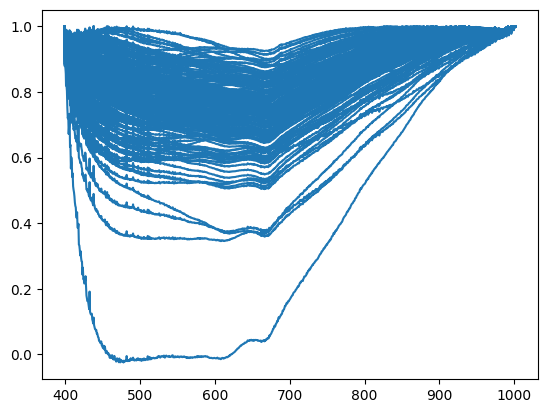

In [35]:
from tqdm import tqdm

spl_coeffs = []

X = remove_continuum(denoised_mnf, bands=bands)

nrows_roi, ncols_roi = denoised_mnf.shape[:2]
npixels_roi = nrows_roi * ncols_roi

for I in tqdm(range(npixels_roi)):
    i, j = divmod(I, ncols_roi)
    y = X[i, j, :]
    spl = make_lsq_spline(bands, y, t=knots_padded, k=DEGREE)
    if I % 1000 == 0:
        plt.plot(bands, y, c=f'C{I // 1000}')
    spl_coeffs.append(spl.c)

In [36]:
spl_coeffs_arr = np.array(spl_coeffs)

In [37]:
spl_coeffs_arr.min(), spl_coeffs_arr.max()

(np.float64(-0.15874317947108554), np.float64(1.0086207696573024))

In [38]:
from sklearn.decomposition import NMF

model = NMF(max_iter=10000, init='nndsvd', n_components=4)

spl_coeffs_arr[spl_coeffs_arr > 1] = 1

X = 1 - spl_coeffs_arr

W = model.fit_transform(X)

C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\.venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


In [40]:
H = model.components_.max(axis=0) - model.components_

In [41]:
W.min(), W.max(), H.min(), H.max()

(np.float64(0.0),
 np.float64(0.326962467032398),
 np.float64(0.0),
 np.float64(6.847187705827132))

In [42]:
W.shape, H.shape

((185220, 10), (10, 17))

In [43]:
model.reconstruction_err_

np.float64(0.5524120358863399)

In [44]:
import math
math.prod([nrows_roi, ncols_roi])

185220

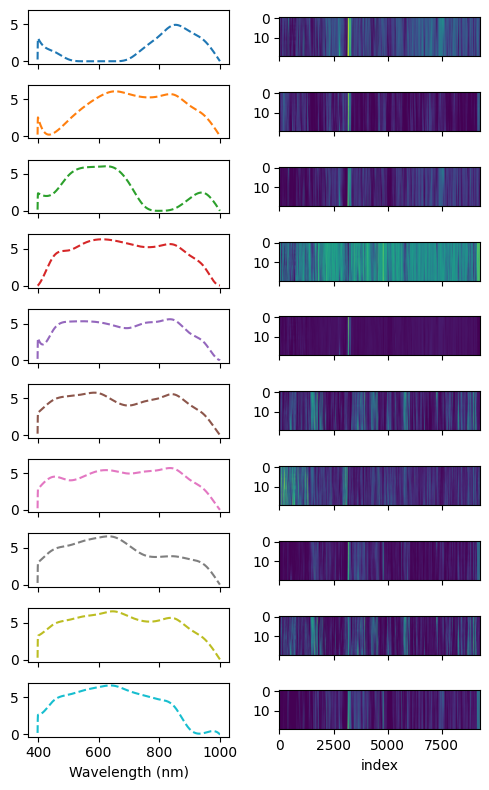

In [49]:
n_inner = W.shape[1]

fig, axs = plt.subplots(ncols=2, nrows=n_inner, sharex='col', sharey='col', layout='tight', figsize=(5, 8))

for i in range(n_inner):
    # spl = BSpline(c=spl_coeffs[i, :], t=knots_padded, k=DEGREE)
    spl_nmf = BSpline(c=H[i, :], t=knots_padded, k=DEGREE)
    # plt.plot(bands, spl(bands), c=f'C{i}')
    axs[i, 0].plot(bands, spl_nmf(bands), c=f'C{i}', linestyle='--')
    # axs[i, 1].stem(W[:, i])
    axs[i, 1].imshow(W[:, i].reshape((nrows_roi, ncols_roi)).T, aspect=90)
axs[-1, 0].set_xlabel('Wavelength (nm)')
axs[-1, 1].set_xlabel('index')
fig.savefig('temp.pdf')

## PCA

In [ ]:
model = PCA(max_iter=10000, init='nndsvd', n_components=10)

X = np.array(spl_coeffs)
...